2025/02/03 - Aarjeyan Shrestha

## Bike Sharing dataset
Create a regression model to predict the 'count'

make sure to include the hyperparameter tuning, k fold validation, normalization, outlier treatment etc

Use regular method and also use optimal. binning in your solutions (2 solution)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
bike_data = pd.read_csv("bike_sharing_data.csv")

In [4]:
bike_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1/1/2011 0:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,1/1/2011 1:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,1/1/2011 2:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,1/1/2011 3:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,1/1/2011 4:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,12/31/2012 19:00,1,0,1,2,10.66,12.880,60,11.0014,5,206,211
17375,12/31/2012 20:00,1,0,1,2,10.66,12.880,60,11.0014,4,140,144
17376,12/31/2012 21:00,1,0,1,1,10.66,12.880,60,11.0014,3,96,99
17377,12/31/2012 22:00,1,0,1,1,10.66,13.635,56,8.9981,4,90,94


In [5]:
# Convert datetime column to datetime format
bike_data['datetime'] = pd.to_datetime(bike_data['datetime'])
bike_data['hour'] = bike_data['datetime'].dt.hour

# Drop datetime column
bike_data.drop(columns=['datetime'], inplace=True)

In [6]:
# Define features and target
X = bike_data.drop(columns=['count', 'casual', 'registered'])
y = bike_data['count']

# Identify categorical and numerical features
categorical_features = ['season', 'holiday', 'workingday', 'weather']
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']

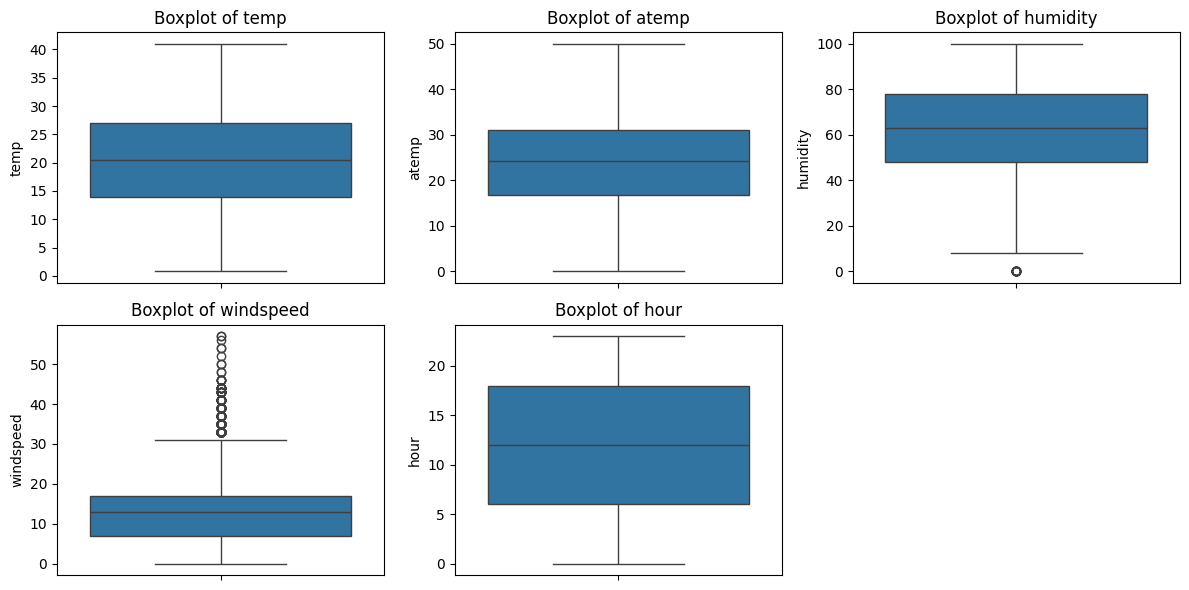

In [21]:
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']

plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=bike_data[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

Bike rentals on the different hours of the day

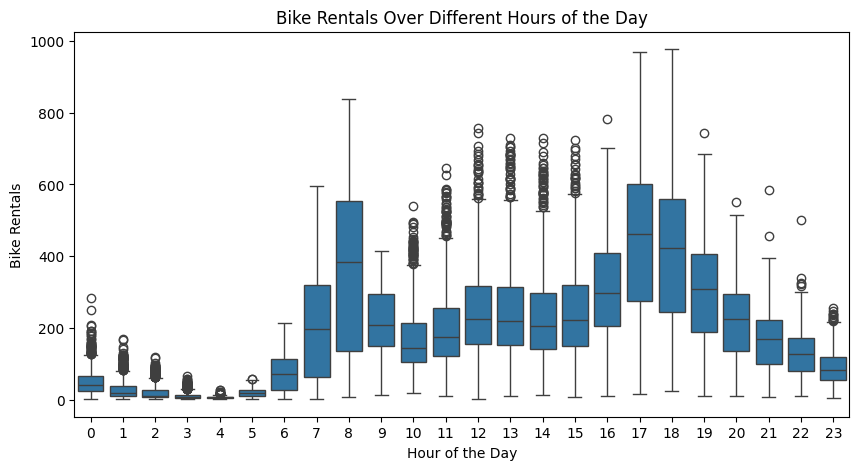

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="hour", y="count", data=bike_data)
plt.xlabel("Hour of the Day")
plt.ylabel("Bike Rentals")
plt.title("Bike Rentals Over Different Hours of the Day")
plt.show()

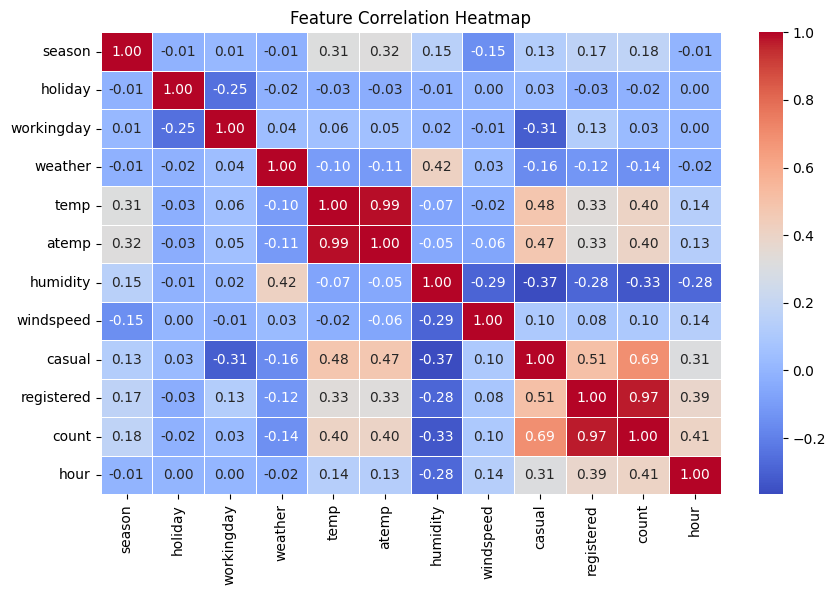

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(bike_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [10]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['temp',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed',
                                                                          'hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['season',
                                                                          'holiday',
                                                                          'workingday',
                                                                          'weather'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='r2')

In [13]:
# Evaluate the best model
y_pred = grid_search.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Best Model RMSE: {rmse:.2f}")
print(f"Best Model R² Score: {r2:.2f}")

Best Model RMSE: 63.92
Best Model R² Score: 0.87


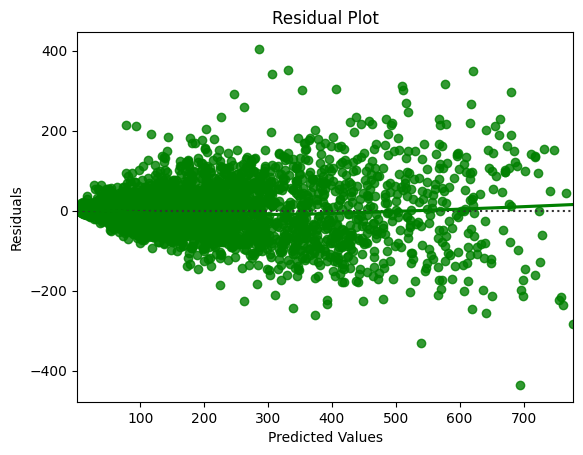

In [14]:
# Visualization of residuals
sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, color="g")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [15]:
# Optimal Binning using KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_train['temp_binned'] = kbins.fit_transform(X_train[['temp']])
X_test['temp_binned'] = kbins.transform(X_test[['temp']])

In [16]:
# Update numerical features
numerical_features.remove('temp')
numerical_features.append('temp_binned')

In [17]:
# Update preprocessor
preprocessor_binned = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [18]:
# Hyperparameter tuning for the binning model
model_pipeline_binned = Pipeline([
    ('preprocessor', preprocessor_binned),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_binned = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20]
}

grid_search_binned = GridSearchCV(model_pipeline_binned, param_grid_binned, cv=5, scoring='r2')
grid_search_binned.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['atemp',
                                                                          'humidity',
                                                                          'windspeed',
                                                                          'hour',
                                                                          'temp_binned']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['season',
                                                                          'holiday',
                                                                          'workingday',
                                                                          'weather'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='r2')

In [19]:
# Evaluate the best binned model
y_pred_binned = grid_search_binned.best_estimator_.predict(X_test)
rmse_binned = np.sqrt(mean_squared_error(y_test, y_pred_binned))
r2_binned = r2_score(y_test, y_pred_binned)
print(f"Optimal Binning Model RMSE: {rmse_binned:.2f}")
print(f"Optimal Binning Model R² Score: {r2_binned:.2f}")

Optimal Binning Model RMSE: 64.38
Optimal Binning Model R² Score: 0.86


In [20]:
# Comparison of models
results_df = pd.DataFrame({
    'Model': ['Standard Regression', 'Optimal Binning Regression'],
    'RMSE': [rmse, rmse_binned],
    'R² Score': [r2, r2_binned]
})
print(results_df)

                        Model       RMSE  R² Score
0         Standard Regression  63.922481  0.865480
1  Optimal Binning Regression  64.382599  0.863536


#### Comparison between the regular model and Binning model

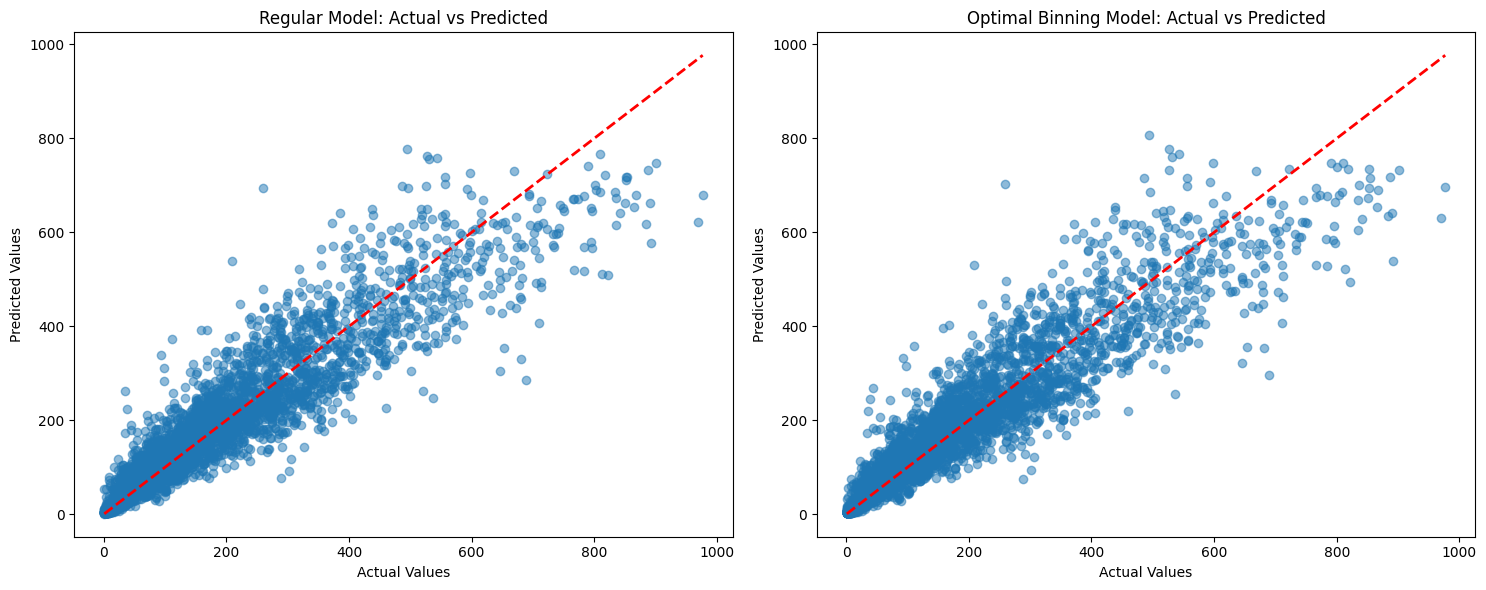

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Regular model
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('Regular Model: Actual vs Predicted')

# Binning model
ax2.scatter(y_test, y_pred_binned, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Optimal Binning Model: Actual vs Predicted')

plt.tight_layout()
plt.show()